In [31]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
import statistics
from sklearn import preprocessing
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os.path

In [32]:
ticker = "FAS"

In [65]:
def getDB(ticker):
    tick = ticker
    # Load data
    data = yf.Ticker(tick)
    df = data.history(period="3y", interval="1d")
#     df = data.history(start="2018-12-01", end="2020-03-01")
#     start="2017-01-01", end="2017-04-30"
    
    # add data points
    df['close_per1'] = df.ta.percent_return(1)*100
    df['sma10'] = df.ta.sma(length=10)
    df['williams'] = df.ta.willr()


    df = df[[
            'open','close','sma10','williams','close_per1'
            ]]

    df = df.dropna()
    
    return df

In [34]:
data = getDB(ticker)
print(data['close_per1'].std())
print(data.head(5))
print(data.tail(5))

5.096166027111942
                 open      close      sma10   williams  close_per1
date                                                              
2019-01-18  53.487754  54.967037  49.258179  -0.559063    4.245093
2019-01-22  53.818647  53.400166  50.024096 -11.809939   -2.850566
2019-01-23  54.061958  53.526691  50.731622 -10.901423    0.236939
2019-01-24  53.079013  53.993832  51.410925  -8.702622    0.872724
2019-01-25  55.093560  55.580166  52.188521  -5.587977    2.937992
                  open       close       sma10   williams  close_per1
date                                                                 
2021-12-27  129.820007  132.520004  126.454931 -12.336443    2.896196
2021-12-28  132.479996  132.509995  127.225233 -13.113711   -0.007553
2021-12-29  133.600006  132.289993  127.731278 -14.056528   -0.166026
2021-12-30  133.139999  131.279999  128.028655 -18.384868   -0.763470
2021-12-31  130.720001  130.940002  127.923165 -19.841926   -0.258986


In [35]:
data.iloc[1]
data.index[0]

Timestamp('2019-01-18 00:00:00')

In [66]:
def set_data(ticker):
    df = getDB(ticker)

    df['CP_ol'] = 0 # open to close day percentage [classify by 0,1,2]
    df['CO_il'] = 0 # close(i) to open(i+1) price [classify by 0,1]
    df['SMA10_il'] = 0 # sma(10 day) compared to close price (i)
    df['W_il'] = 0 # Williams [classify by -1,0,1]
    
    value = df['close_per1'].std()
    
    # setting the outputs in the df
    for i in range(len(df)):
        if df.iloc[i]['close_per1'] > value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 2
        elif df.iloc[i]['close_per1'] < -value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 1
        else:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 0
    
    # setting the inputs in the df
    for i in range(len(df)-1):
#         try:
#         print("close data:",df.index[i])
#         print("open data:",df.index[i+1])
#         print("putting data here:",df.index[i+1])
#         print()
        if df.iloc[i]['close'] < df.iloc[i+1]['open']:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = 1
        else:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = 0
#         except:
#             df.iloc[i+1, df.columns.get_loc('CO_il')] = np.nan
            
    
#     # setting the inputs in the df
#     for i in range(len(df)):
#         try:
#             if df.iloc[i]['close'] > df.iloc[i]['sma10']:
#                 df.iloc[i, df.columns.get_loc('SMA10_il')] = 1
#             else:
#                 df.iloc[i, df.columns.get_loc('SMA10_il')] = 0
#         except:
#             df.iloc[i, df.columns.get_loc('SMA10_il')] = np.nan
       
    # setting the inputs in the df
    for i in range(len(df)-1):
#         try:
        if df.iloc[i+1]['open'] > df.iloc[i]['sma10']:
            df.iloc[i+1, df.columns.get_loc('SMA10_il')] = 1
        else:
            df.iloc[i+1, df.columns.get_loc('SMA10_il')] = 0
#         except:
#             df.iloc[i+1, df.columns.get_loc('SMA10_il')] = np.nan
    
    
    # setting the inputs in the df
    for i in range(len(df)):
        if df.iloc[i]['williams'] > -30: # overbought
            df.iloc[i, df.columns.get_loc('W_il')] = -1
        elif df.iloc[i]['williams'] < -70: # oversold
            df.iloc[i, df.columns.get_loc('W_il')] = 1
        else:
            df.iloc[i, df.columns.get_loc('W_il')] = 0 # neutral
    
    df['W_il'] = df.W_il.shift(1)
#     df['SMA10_il'] = df.SMA10_il.shift(1)
    
    # deleting data that is not normalized
    del df['open']
    del df['close']
    del df['sma10']
    del df['williams']
#     del df['close_per1']
    
    # reformating
    df = df[[
            'W_il','SMA10_il','CO_il','CP_ol','close_per1'
            ]]
    
    return df

In [37]:
# # df = set_data(ticker)
# # print(data.tail(5))
# print(df.tail(10))
# df['W_il'] = df.W_il.shift(1)
# df['SMA10_il'] = df.SMA10_il.shift(1)
# # df['W_il'] = df['W_il'].shift(1)
# # df['SMA_il'] = df['SMA_il'].shift(1)
# # df['W_il'].shift(1)
# # df['SMA_il'].shift(1)
# print(df.tail(10))

            W_il  SMA10_il  CO_il  CP_ol  close_per1
date                                                
2021-12-17   0.0       1.0      0      1   -6.110265
2021-12-20   1.0       0.0      0      1   -5.872415
2021-12-21   0.0       0.0      1      2    6.239070
2021-12-22   0.0       0.0      0      0    1.984991
2021-12-23  -1.0       1.0      1      0    1.898880
2021-12-27   0.0       1.0      1      0    2.896196
2021-12-28   1.0       1.0      0      0   -0.007553
2021-12-29   0.0       1.0      1      0   -0.166026
2021-12-30   0.0       1.0      1      0   -0.763470
2021-12-31  -1.0       1.0      0      0   -0.706126
            W_il  SMA10_il  CO_il  CP_ol  close_per1
date                                                
2021-12-17   0.0       1.0      0      1   -6.110265
2021-12-20   0.0       1.0      0      1   -5.872415
2021-12-21   1.0       0.0      1      2    6.239070
2021-12-22   0.0       0.0      0      0    1.984991
2021-12-23   0.0       0.0      1      0    1.

In [67]:
def process_train(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[0:-SHIFT]
        
        del df['close_per1']

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")



In [68]:
def process_test(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]
        
        del df['close_per1']

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")

In [70]:
SEQ_LEN = 2  # how long of a preceeding sequence to collect for RNN
# FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
SHIFT = 150  # how far to shift the data so it can be back testest
BATCH_SIZE = 64 # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
EPOCHS = 750 # how many passes through our data


tickers_train = [ticker]
tickers_test = [ticker]

train_x, train_y = process_train(tickers_train, SEQ_LEN,SHIFT)
validation_x, validation_y = process_test(tickers_test, SEQ_LEN, SHIFT)

In [71]:
print(train_x[0])
print('training data length: %d' % (len(train_x)))
print('validation data length: %d' % (len(validation_x)))

[[-1.  1.  1.]
 [-1.  1.  0.]]
training data length: 162
validation data length: 27


In [72]:
## Building the RNN ##
print()
print("length of train data: ", len(train_x))
print("length of validation data: ", len(validation_x))
print()

model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1:]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(64, activation='tanh'))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)
)

print()
print()

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()


length of train data:  162
length of validation data:  27

Epoch 1/750
3/3 [==============================] - 3s 295ms/step - loss: 1.1574 - accuracy: 0.5000 - val_loss: 1.0958 - val_accuracy: 0.5556
Epoch 2/750
3/3 [==============================] - 0s 13ms/step - loss: 1.1325 - accuracy: 0.5123 - val_loss: 1.0957 - val_accuracy: 0.5556
Epoch 3/750
3/3 [==============================] - 0s 14ms/step - loss: 1.1522 - accuracy: 0.4691 - val_loss: 1.0957 - val_accuracy: 0.4444
Epoch 4/750
3/3 [==============================] - 0s 14ms/step - loss: 1.1448 - accuracy: 0.4938 - val_loss: 1.0956 - val_accuracy: 0.4444
Epoch 5/750
3/3 [==============================] - 0s 13ms/step - loss: 1.1352 - accuracy: 0.5000 - val_loss: 1.0955 - val_accuracy: 0.4444
Epoch 6/750
3/3 [==============================] - 0s 13ms/step - loss: 1.1299 - accuracy: 0.4938 - val_loss: 1.0954 - val_accuracy: 0.4444
Epoch 7/750
3/3 [==============================] - 0s 13ms/step - loss: 1.1286 - accuracy: 0.4938 -

Epoch 59/750
3/3 [==============================] - 0s 13ms/step - loss: 0.9602 - accuracy: 0.5802 - val_loss: 1.0848 - val_accuracy: 0.3704
Epoch 60/750
3/3 [==============================] - 0s 13ms/step - loss: 0.9582 - accuracy: 0.5741 - val_loss: 1.0844 - val_accuracy: 0.3704
Epoch 61/750
3/3 [==============================] - 0s 12ms/step - loss: 0.9668 - accuracy: 0.5679 - val_loss: 1.0841 - val_accuracy: 0.3704
Epoch 62/750
3/3 [==============================] - 0s 13ms/step - loss: 0.9516 - accuracy: 0.5679 - val_loss: 1.0837 - val_accuracy: 0.3704
Epoch 63/750
3/3 [==============================] - 0s 13ms/step - loss: 0.9473 - accuracy: 0.5679 - val_loss: 1.0833 - val_accuracy: 0.3704
Epoch 64/750
3/3 [==============================] - 0s 12ms/step - loss: 0.9582 - accuracy: 0.5617 - val_loss: 1.0829 - val_accuracy: 0.3704
Epoch 65/750
3/3 [==============================] - 0s 13ms/step - loss: 0.9486 - accuracy: 0.5864 - val_loss: 1.0824 - val_accuracy: 0.3704
Epoch 66/750


Epoch 117/750
3/3 [==============================] - 0s 12ms/step - loss: 0.9012 - accuracy: 0.5864 - val_loss: 1.0424 - val_accuracy: 0.4074
Epoch 118/750
3/3 [==============================] - 0s 13ms/step - loss: 0.8824 - accuracy: 0.5926 - val_loss: 1.0412 - val_accuracy: 0.4074
Epoch 119/750
3/3 [==============================] - 0s 12ms/step - loss: 0.9032 - accuracy: 0.5864 - val_loss: 1.0401 - val_accuracy: 0.4074
Epoch 120/750
3/3 [==============================] - 0s 12ms/step - loss: 0.9021 - accuracy: 0.5802 - val_loss: 1.0389 - val_accuracy: 0.4074
Epoch 121/750
3/3 [==============================] - 0s 13ms/step - loss: 0.9005 - accuracy: 0.5988 - val_loss: 1.0378 - val_accuracy: 0.4074
Epoch 122/750
3/3 [==============================] - 0s 13ms/step - loss: 0.8894 - accuracy: 0.5802 - val_loss: 1.0366 - val_accuracy: 0.4074
Epoch 123/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8937 - accuracy: 0.5988 - val_loss: 1.0354 - val_accuracy: 0.4074
Epoch 

Epoch 175/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8589 - accuracy: 0.6049 - val_loss: 0.9604 - val_accuracy: 0.5926
Epoch 176/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8520 - accuracy: 0.6111 - val_loss: 0.9588 - val_accuracy: 0.5926
Epoch 177/750
3/3 [==============================] - 0s 13ms/step - loss: 0.8647 - accuracy: 0.5926 - val_loss: 0.9572 - val_accuracy: 0.5926
Epoch 178/750
3/3 [==============================] - 0s 13ms/step - loss: 0.8620 - accuracy: 0.6049 - val_loss: 0.9557 - val_accuracy: 0.5926
Epoch 179/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8645 - accuracy: 0.5926 - val_loss: 0.9542 - val_accuracy: 0.5926
Epoch 180/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8506 - accuracy: 0.6235 - val_loss: 0.9527 - val_accuracy: 0.5556
Epoch 181/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8504 - accuracy: 0.6111 - val_loss: 0.9511 - val_accuracy: 0.5556
Epoch 

Epoch 233/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8321 - accuracy: 0.6481 - val_loss: 0.8770 - val_accuracy: 0.6296
Epoch 234/750
3/3 [==============================] - 0s 11ms/step - loss: 0.8216 - accuracy: 0.6420 - val_loss: 0.8759 - val_accuracy: 0.6296
Epoch 235/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8335 - accuracy: 0.6543 - val_loss: 0.8749 - val_accuracy: 0.6296
Epoch 236/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8267 - accuracy: 0.6605 - val_loss: 0.8738 - val_accuracy: 0.6296
Epoch 237/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8329 - accuracy: 0.6358 - val_loss: 0.8728 - val_accuracy: 0.6296
Epoch 238/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8210 - accuracy: 0.6420 - val_loss: 0.8718 - val_accuracy: 0.6296
Epoch 239/750
3/3 [==============================] - 0s 13ms/step - loss: 0.8337 - accuracy: 0.6420 - val_loss: 0.8709 - val_accuracy: 0.6296
Epoch 

Epoch 291/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8102 - accuracy: 0.6852 - val_loss: 0.8310 - val_accuracy: 0.6667
Epoch 292/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8256 - accuracy: 0.6481 - val_loss: 0.8302 - val_accuracy: 0.6667
Epoch 293/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8122 - accuracy: 0.6728 - val_loss: 0.8297 - val_accuracy: 0.6667
Epoch 294/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8049 - accuracy: 0.6667 - val_loss: 0.8290 - val_accuracy: 0.6667
Epoch 295/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8037 - accuracy: 0.6543 - val_loss: 0.8284 - val_accuracy: 0.6667
Epoch 296/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8076 - accuracy: 0.6605 - val_loss: 0.8278 - val_accuracy: 0.6667
Epoch 297/750
3/3 [==============================] - 0s 12ms/step - loss: 0.8151 - accuracy: 0.6790 - val_loss: 0.8270 - val_accuracy: 0.6667
Epoch 

Epoch 349/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7971 - accuracy: 0.6543 - val_loss: 0.8106 - val_accuracy: 0.6667
Epoch 350/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7723 - accuracy: 0.6728 - val_loss: 0.8104 - val_accuracy: 0.6667
Epoch 351/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7961 - accuracy: 0.6358 - val_loss: 0.8098 - val_accuracy: 0.6667
Epoch 352/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7930 - accuracy: 0.6667 - val_loss: 0.8098 - val_accuracy: 0.6667
Epoch 353/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7917 - accuracy: 0.6420 - val_loss: 0.8095 - val_accuracy: 0.6667
Epoch 354/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7873 - accuracy: 0.6667 - val_loss: 0.8095 - val_accuracy: 0.6667
Epoch 355/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7898 - accuracy: 0.6728 - val_loss: 0.8095 - val_accuracy: 0.6667
Epoch 

Epoch 407/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7741 - accuracy: 0.6852 - val_loss: 0.7939 - val_accuracy: 0.7037
Epoch 408/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7800 - accuracy: 0.6728 - val_loss: 0.7936 - val_accuracy: 0.7037
Epoch 409/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7760 - accuracy: 0.6728 - val_loss: 0.7931 - val_accuracy: 0.7037
Epoch 410/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7735 - accuracy: 0.6790 - val_loss: 0.7929 - val_accuracy: 0.7037
Epoch 411/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7806 - accuracy: 0.6605 - val_loss: 0.7926 - val_accuracy: 0.7037
Epoch 412/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7685 - accuracy: 0.6605 - val_loss: 0.7923 - val_accuracy: 0.7037
Epoch 413/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7696 - accuracy: 0.6852 - val_loss: 0.7924 - val_accuracy: 0.7037
Epoch 

Epoch 465/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7637 - accuracy: 0.6914 - val_loss: 0.7898 - val_accuracy: 0.7037
Epoch 466/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7638 - accuracy: 0.6852 - val_loss: 0.7894 - val_accuracy: 0.7037
Epoch 467/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7566 - accuracy: 0.6605 - val_loss: 0.7891 - val_accuracy: 0.7037
Epoch 468/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7697 - accuracy: 0.6790 - val_loss: 0.7887 - val_accuracy: 0.7037
Epoch 469/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7553 - accuracy: 0.6728 - val_loss: 0.7880 - val_accuracy: 0.7037
Epoch 470/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7518 - accuracy: 0.6667 - val_loss: 0.7876 - val_accuracy: 0.7037
Epoch 471/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7580 - accuracy: 0.6728 - val_loss: 0.7874 - val_accuracy: 0.7037
Epoch 

Epoch 523/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7702 - accuracy: 0.6543 - val_loss: 0.7777 - val_accuracy: 0.7037
Epoch 524/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7707 - accuracy: 0.6605 - val_loss: 0.7774 - val_accuracy: 0.7037
Epoch 525/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7530 - accuracy: 0.6728 - val_loss: 0.7775 - val_accuracy: 0.7037
Epoch 526/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7448 - accuracy: 0.6790 - val_loss: 0.7775 - val_accuracy: 0.7037
Epoch 527/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7549 - accuracy: 0.6667 - val_loss: 0.7774 - val_accuracy: 0.7037
Epoch 528/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7528 - accuracy: 0.6852 - val_loss: 0.7776 - val_accuracy: 0.7037
Epoch 529/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7467 - accuracy: 0.6728 - val_loss: 0.7776 - val_accuracy: 0.7037
Epoch 

Epoch 581/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7382 - accuracy: 0.6790 - val_loss: 0.7727 - val_accuracy: 0.7037
Epoch 582/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7572 - accuracy: 0.6481 - val_loss: 0.7727 - val_accuracy: 0.7037
Epoch 583/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7384 - accuracy: 0.6914 - val_loss: 0.7727 - val_accuracy: 0.7037
Epoch 584/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7444 - accuracy: 0.6852 - val_loss: 0.7725 - val_accuracy: 0.7037
Epoch 585/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7480 - accuracy: 0.6667 - val_loss: 0.7726 - val_accuracy: 0.7037
Epoch 586/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7596 - accuracy: 0.6667 - val_loss: 0.7729 - val_accuracy: 0.7037
Epoch 587/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7563 - accuracy: 0.6543 - val_loss: 0.7727 - val_accuracy: 0.7037
Epoch 

Epoch 639/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7387 - accuracy: 0.6790 - val_loss: 0.7677 - val_accuracy: 0.7037
Epoch 640/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7295 - accuracy: 0.6728 - val_loss: 0.7674 - val_accuracy: 0.7037
Epoch 641/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7356 - accuracy: 0.6728 - val_loss: 0.7673 - val_accuracy: 0.7037
Epoch 642/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7480 - accuracy: 0.6543 - val_loss: 0.7670 - val_accuracy: 0.7037
Epoch 643/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7398 - accuracy: 0.6728 - val_loss: 0.7667 - val_accuracy: 0.7037
Epoch 644/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7383 - accuracy: 0.6914 - val_loss: 0.7667 - val_accuracy: 0.7037
Epoch 645/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7392 - accuracy: 0.6852 - val_loss: 0.7666 - val_accuracy: 0.7037
Epoch 

Epoch 697/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7294 - accuracy: 0.6914 - val_loss: 0.7626 - val_accuracy: 0.7037
Epoch 698/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7340 - accuracy: 0.6790 - val_loss: 0.7627 - val_accuracy: 0.7037
Epoch 699/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7243 - accuracy: 0.6852 - val_loss: 0.7628 - val_accuracy: 0.7037
Epoch 700/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7417 - accuracy: 0.6790 - val_loss: 0.7627 - val_accuracy: 0.7037
Epoch 701/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7308 - accuracy: 0.6790 - val_loss: 0.7627 - val_accuracy: 0.7037
Epoch 702/750
3/3 [==============================] - 0s 12ms/step - loss: 0.7249 - accuracy: 0.6852 - val_loss: 0.7627 - val_accuracy: 0.7037
Epoch 703/750
3/3 [==============================] - 0s 13ms/step - loss: 0.7288 - accuracy: 0.6852 - val_loss: 0.7627 - val_accuracy: 0.7037
Epoch 

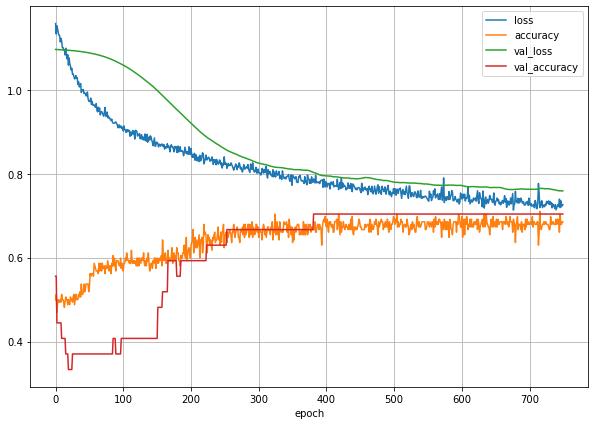

Test loss: 0.7588381767272949
Test accuracy: 0.7037037014961243


In [73]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('epoch')
plt.grid()
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [74]:
def process_test_buys(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!
        
        Sequential_data = Sequential_data + sequential_data
        
    X = []; y = []; z = []
    for seq, target, actual in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        z.append(actual)

    return np.array(X).astype("float64"), np.array(y).astype("uint8"), np.array(z).astype("float64")

In [75]:
last_trading_days = 100
test_x, test_y, test_z = process_test_buys(tickers_test, SEQ_LEN, last_trading_days)

In [76]:
output = model.predict(test_x)

In [77]:
results = []; total = 0
for i, j in zip(output, test_z):
    if np.argmax(i) == 2:
        total += 1
#         results.append([i,j])
        results.append(j)

In [78]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Average daily return: 1.512388 percent, over 29 trades.
You started with $5000 and finished with $7607 after 29 trades.


In [79]:
print(results)

[2.347376935288459, -1.5694116217555676, -2.2103989018587344, -2.2268716518957676, 3.1595210480641622, -3.909364410873828, -0.5628833462154925, -0.5422291794853207, 4.26302747306484, 7.179760700093607, 5.41504115382172, 4.204014801309497, 0.10475245871657268, 0.8335003685586262, 0.6304627786145156, -0.06263956455113684, -1.2897125600689563, 4.043363727909655, 4.305987434505565, 1.04535839203721, -3.2955254715018367, 8.421855178188121, -4.726440274769306, 3.8091279399722566, 5.167216721138401, 0.3401550511611173, 0.8462584169203646, 6.239069927025254, 1.8988795854689489]


In [80]:
results = []; total = 0
for i, j in zip(output, test_z):
    if i[2] > 0.6:
        total += 1
#         results.append([i,j])
        results.append(j)

In [81]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Average daily return: 1.047097 percent, over 15 trades.
You started with $5000 and finished with $5798 after 15 trades.


In [82]:
print(results)

[-2.2103989018587344, -3.909364410873828, -0.5628833462154925, -0.5422291794853207, 4.26302747306484, 0.8335003685586262, 0.6304627786145156, -1.2897125600689563, 4.043363727909655, -3.2955254715018367, 8.421855178188121, 0.3401550511611173, 0.8462584169203646, 6.239069927025254, 1.8988795854689489]


model.summary()

In [ ]:
# model.get_weights()

In [ ]:

if os.path.isfile('FAS_model.h5') is False:
    model.save('FAS_model.h5')


In [ ]:
model1 = load_model('FAS_model.h5')

In [ ]:
model1.summary()